# Recommendation System with Probabilistic Matrix Factorization

## Introduction

With the rise of streaming media and video website such as Netflix, YouTube, Spotify and many other platforms, recommendation (recommender) system is widely used to predict users' potential interests on the items which they haven't watched/listened yet. 

In this project, we specifically aim to apply probabilistic matrix factorization to solve this problem. 

## Data

To build the predictive model we gather user preference data on animes (hand-drawn and computer animation originated from Japan), which is available at [Kaggle](https://www.kaggle.com/CooperUnion/anime-recommendations-database). 

As matrix factorization could be computationally heavy, we implement our idea on a small subset of data. It is composed of 100 Users and 200 Anime. For Model training, we split our data with a train/test ratio of 9:1. 

In [8]:
import torch
import pyro
import numpy as np
from matplotlib import pyplot as plt
from utils import load_makematrix
from GaussianMF import run_GaussianMF
from PoissonMF import run_PoissonMF
from visualization import *

# latent vector dimension
k = 30

# make the data
anime_data, anime_matrix_train, anime_data_test = load_makematrix("data/ratings_100_200_real.csv", split=True)

In [17]:
# Sample data and number of users and animes
print(anime_matrix_train.shape)

(100, 200)


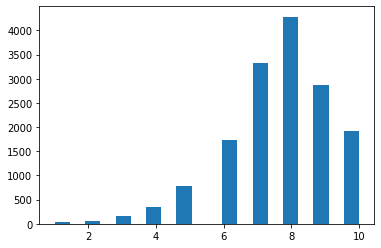

In [6]:
# Plot the distribution of ratings
plt.hist(anime_data.rating, bins=20)
plt.show()

In [9]:
print('The mean of ratings is', np.mean(anime_data[anime_data.rating > 0].rating))
print('The standard deviation of ratings is', np.std(anime_data[anime_data.rating > 0].rating))

The mean of ratings is 7.6670970240784975
The standard deviation of ratings is 1.5856381149038559


## Box's loop 1

### Model 1: Gaussian 

The idea of matrix factorization is to decompose the rating matrix into two latent features U and V with latent factor being a desgnated constant. We experientally found out that a latent factor K between 20 and 30 is a sweet range for our purpose. K=10 will lower the model performance, and K greater than 50 will have no improvemet in terms of performance but increase computation time significantly. 

Ratings: $r_{ij} \subset [1, 10]$

$$
r_{ij} \sim \mathcal{N}(u^T_i v_j, \sigma^2)
$$


User latent feature: a matrix with dimension $100*k$, k being the latent factor

Anime latent feature: a matrix with dimension $200*k$

In our first model, we assume that the user and anime latent feature are k-dimensional latent variable vectors distributed as:: 

$$
u_i \sim \mathcal{N}_k(0, I\sigma^2_u); \\\\ v_j \sim \mathcal{N}_k(0, I\sigma^2_v) 
$$

Beside that, we also assume that $\sigma \sim \mathrm{Uniform}(0, 10)$; 

The predicted matrix is 

$$
\hat{R}_{m \times n} = U^T V
$$

The likelihood of our data is: 

$$
\ell(R|U,V,\sigma) = \prod_{i=1}^m\prod_{j=1}^n [\mathcal{N}(r_{ij}|u^T_i v_j, \sigma^2)]^{I_{ij}}
$$

where $I_{ij}=1$ if user i had rated anime j and 0 otherwise. 

### Inference on model 1

**MAP inference**

In [10]:
loss_list, mae_list = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, method="map", mae_tol = 0.05)

[iter 0]  loss: 88107957.1728 Test MAE: 7.6335
[iter 250]  loss: 9710353.9180 Test MAE: 7.6335
[iter 500]  loss: 9703657.6773 Test MAE: 7.6335
[iter 750]  loss: 9703656.7566 Test MAE: 7.6335


**Criticism**

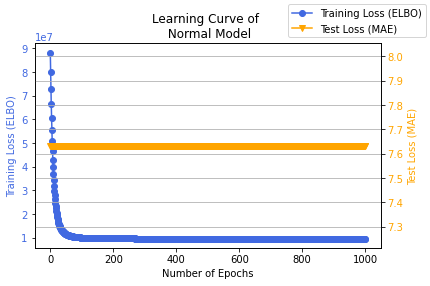

In [2]:
learning_curve_plot(loss_list, mae_list)

**SVI inference**

In [39]:
import PoissonMFsianMF
import importlib
importlib.reload(GaussianMF)
from GaussianMF import run_GaussianMF

In [40]:
loss_list, mae_list = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, method = "svi", mae_tol = 0.02)

[iter 0]  loss: 168894882.5039 Test MAE: 7.6332
[iter 250]  loss: 5996485.3684 Test MAE: 0.9610
[iter 500]  loss: 4873891.0625 Test MAE: 0.8980
[stop at iter 504]  loss: 4825559.0039 Test MAE: 0.9229


**SVI criticism**

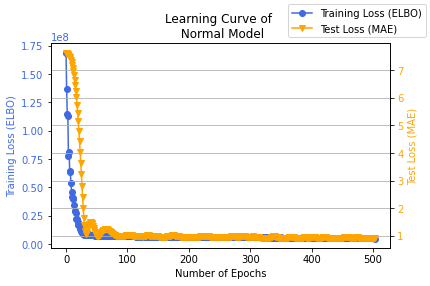

In [41]:
learning_curve_plot(loss_list, mae_list)

In [13]:
import pyro
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
print(f'SVI estimate of R: {torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())}')

SVI estimate of R: tensor([[ 7.5021,  5.8325,  5.6572,  ...,  6.8153,  7.8675,  8.5787],
        [ 9.1793,  9.2292,  9.3649,  ...,  8.8388, 10.1325, 10.9313],
        [ 7.5158,  7.6007,  7.8465,  ...,  6.3319,  7.0913,  7.9486],
        ...,
        [ 8.1259,  7.6331,  7.5488,  ...,  7.1623,  7.8088,  8.6252],
        [ 8.3122,  7.8839,  7.7903,  ...,  7.7570,  8.2684,  9.1614],
        [ 8.2058,  7.2644,  7.0296,  ...,  7.8542,  8.6324,  9.4381]],
       grad_fn=<MmBackward>)


In [42]:
print('The MAE is', min(mae_list))

The MAE is 0.8980233973841514


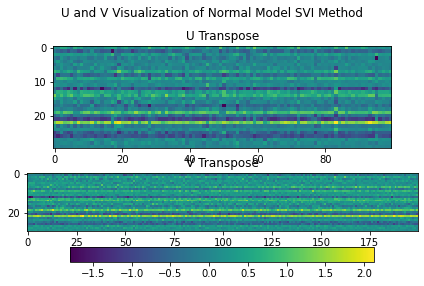

In [43]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import U_V_visualization
U_V_visualization()

In [ ]:
import GaussianMF
import importlib
importlib.reload(GaussianMF)
from GaussianMF import run_GaussianMF

hmc_samples = run_GaussianMF(anime_matrix_train, anime_data_test, k = k, mae_tol = 0.02, method = "hmc")

Warmup:   3%|▎         | 33/1200 [11:49, 64.42s/it, step size=4.30e-05, acc. prob=0.762]

## Box's loop 2
### Model 2: Poisson

With other things similar to model 1, we assume a difference distribution for ratings. Specifically, we assume that 

$$r_{ij} \sim \mathcal{Poisson} (u^T_i v_j)$$

then the likelihood is: 

$$
\ell(R|U,V,\sigma) = \prod_{i=1}^m\prod_{j=1}^n [\mathcal{Poisson}(r_{ij}|u^T_i v_j)]^{I_{ij}}
$$

where $I_{ij}=1$ if user i had rated anime j and 0 otherwise. 

### Inference on model 2

In [45]:
import PoissonMF
import importlib
importlib.reload(PoissonMF)
from PoissonMF import run_PoissonMF

In [50]:
loss_list, mae_list = run_PoissonMF(anime_matrix_train, anime_data_test, k = k, n_steps=5000, mae_tol = 0.05)

[iter 0]  loss: 72030853.9433 Test MAE: 7.6334
[iter 250]  loss: 24241352.8189 Test MAE: 2.3326
[iter 500]  loss: 14026085.8527 Test MAE: 2.0957
[iter 750]  loss: 9950768.5740 Test MAE: 1.8152
[iter 1000]  loss: 9394501.5975 Test MAE: 1.5973
[iter 1250]  loss: 8396421.9601 Test MAE: 1.4682
[iter 1500]  loss: 7855552.5660 Test MAE: 1.3324
[iter 1750]  loss: 7085680.4448 Test MAE: 1.2498
[iter 2000]  loss: 7139019.4014 Test MAE: 1.1899
[iter 2250]  loss: 6699108.2877 Test MAE: 1.1367
[iter 2500]  loss: 6555851.5182 Test MAE: 1.1061
[iter 2750]  loss: 6344575.6580 Test MAE: 1.0874
[iter 3000]  loss: 6240122.3637 Test MAE: 1.0622
[iter 3250]  loss: 6035576.5384 Test MAE: 1.0381
[iter 3500]  loss: 5971576.4964 Test MAE: 1.0023
[iter 3750]  loss: 5966885.5471 Test MAE: 0.9898
[iter 4000]  loss: 5881193.2099 Test MAE: 0.9886
[iter 4250]  loss: 5851481.6377 Test MAE: 0.9547
[iter 4500]  loss: 5807350.2508 Test MAE: 0.9522
[iter 4750]  loss: 5780740.9340 Test MAE: 0.9382


**SVI criticism**

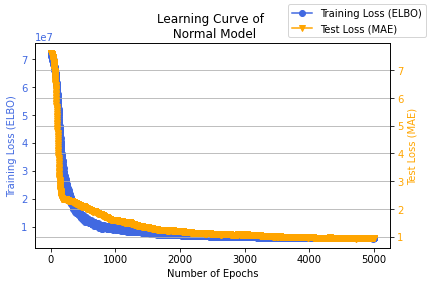

In [51]:
learning_curve_plot(loss_list, mae_list)

In [48]:
R = torch.mm(pyro.param("u_mean"), pyro.param("v_mean").t())
print(f'SVI estimate of R: {R}')

SVI estimate of R: tensor([[ 7.5234,  7.3061,  6.6975,  ..., 12.6670,  7.8941,  8.2612],
        [ 8.9780,  9.4662,  8.8137,  ..., 11.7679,  8.9612,  9.8728],
        [ 7.5954,  7.7740,  7.3056,  ..., 10.3020,  7.5763,  8.1380],
        ...,
        [ 8.5530,  8.3319,  8.0604,  ..., 12.0349,  7.9165,  8.9309],
        [10.4690, 13.3812, 13.4336,  ..., 46.6897, 12.3636, 13.9859],
        [ 8.4885,  8.5923,  8.0451,  ..., 14.4660,  8.3930,  9.0767]],
       grad_fn=<MmBackward>)


In [49]:
print('The MAE is', min(mae_list))

The MAE is 1.054491415485259


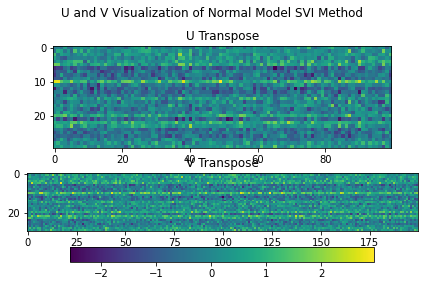

In [28]:
U_V_visualization()